# TP -- Descentes de Gradient

Ce TP vise à apporter les éléments nécessaires pour comprendre les implementations des descentes de gradients, du moins dans un premier cadre naïf. On s'efforcera constamment à comparer les différentes variantes des descentes de gradients que l'on va introduire ; on fera donc du **batch testing**. 

Voici un *outline* des points abordés lors de ce TP.

- Un set de fonctions tests: comment se donne-t-on une fonction numérique? 
- Calculer le gradient d'une fonction: coder une solution en dur ou calcul approché?
- La classe GD: une classe qui sert d'interface pour toutes les descentes qu'on souhaite implémenter. 
- La Descente de Gradient :
    - Calcul du pas : pas constant, *Backtracking*
    - Choix de norme : la classique, la norme infinie
    - Sensibilité aux point initiaux
    - Sensibilité aux nombres de conditionnement
    - Accélération : Momentum, Nesterov, Adam.
- Cas d'application classique: la régression.
- La Méthode de Newton : 
    - La classe MN
    - Comparaison à la GD.
- Face aux contraintes d'égalité.


In [1]:
import warnings
import math
import numpy as np

## Un set de fonctions tests

Il y a différentes facons de se donner une fonction numérique en machine :

- Symboliquement : on se donne une expression symbolique représentant des sommes, différences, produits, quotients et composées de fonctions usuelles.  Dans ce cadre les questions l'opération de dérivation est symbolique et les dérivées obtenues par ce biais sont exactes. Une opération d'évaluation est nécessaire pour passer de l'écriture symbolique d'une fonction au calcul de la valeur qu'elle prend en un point. Vous pouvez vous attarder sur la bibliothèque `sympy` sous python.

- Numériquement : des approximations des fonctions usuelles sont implémentées dans les bibliothèques `math` pour et `numpy` de python. On peut écrire par ce biais les fonctions usuelles comme des fonctions au sens algorithmique du terme. L'évaluation d'une fonction en un point se fait par le biais de l'appel à la fonction avec les paramètres adéquats. Le calcul d'une dérivée s'approche par une expression numérique impliquant les points et les fonctions en jeux où est calculé par ailleurs.

- Approximation : une liste de couples (entrée, sortie) ou encore (point, image). Dans ce cas on approche les dérivées par les tangentes des droites joignants deux points successifs. 

Dans ce TP notre choix s'arrête sur la plus intuitives des démarches ; l'aspect fonction informatique.

### Structure de données

On va se donner un ensemble de familles de fonctions ; une fonction est donnée par une classe qui wrap les attributs:

- `name` : une `str` qui contient le nom de la fonction. 
- `convex` : `bool` spécifiant si la famille de fonction est convexe ou non.
- `dim` : `int` la dimension de l'espace de départ.
- `nb_params` : nombre de paramètres de la famille.
- `value` : une fonction qui prend en entrée un `numpy` array et renvoie un `float` en sortie.
- `grad` : fonction gradient de `function`.
- `hess` : fonction hessienne de `function`.
- `HCN` : fonction nombre de conditionnement de la hessienne de `function`.


In [2]:
class test_function():
    
    def __init__(self, name, value, dim, nb_params, convex=None, grad=None, hess=None, HCN=None):
        self.name = name
        self.value = value
        self.dim = dim
        self.nb_params = nb_params
        self.convex = convex
        self.grad = grad
        self.hess = hess
        self.HCN = HCN

### Fonctions du set de test

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
sns.set_style("whitegrid")

1. Définir des familles de fonctions *convexes* sur $\mathbb{R}$ ayant un nombre de conditionnement uniquement dépendant des paramètres de la famille.  

In [56]:
quad_I_d = {
    "name": "quadratic_1",
    "dim" : 1,
    "nb_params" : 1,
    "convex" : True,
    "value" : (lambda x, gamma: gamma*(x**2) + x + 1),
    "grad"  : (lambda x, gamma: 2*gamma*x + 1),
    "hess"  : (lambda x, gamma: 2*gamma),
    "HCN"   : (lambda x, gamma: 2*gamma)
}

quad_I = test_function(**quad_I_d)

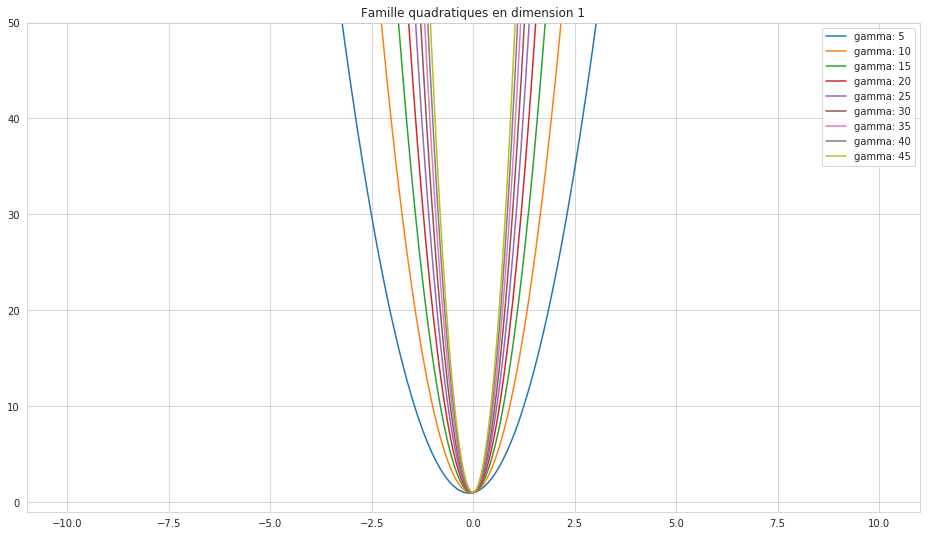

In [6]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(-10, 10, 400)
ax.set_ylim(-1, 50)
for gamma in range(5, 50, 5):
    ax.plot(x, quad_I.value(x, gamma), label="gamma: {}".format(gamma))
ax.set_title("Famille quadratiques en dimension 1")
ax.legend()

In [7]:
cubic_I_d = { 
    "name": "cubic_1",
    "dim" : 1,
    "nb_params" : 1,
    "convex" : False,
    "value" : (lambda x, gamma: x**3 + gamma*x**2 + x + 1),
    "grad"  : (lambda x, gamma: 3*x**2 + 2*gamma*x + 1),
    "hess"  : (lambda x, gamma: 6*x + 2*gamma),
    "HCN"   : (lambda x, gamma: 6*x + 2*gamma)
}

cubic_I = test_function(**cubic_I_d)

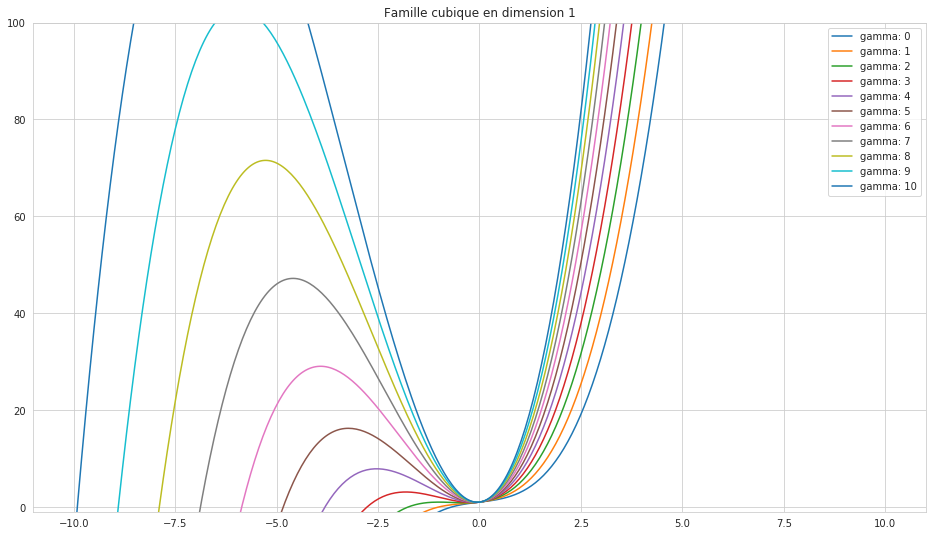

In [8]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(-10, 10, 400)
ax.set_ylim(-1, 100)
for gamma in range(0, 11, 1):
    ax.plot(x, cubic_I.value(x, gamma), label="gamma: {}".format(gamma))
ax.set_title("Famille cubique en dimension 1")
ax.legend()

In [9]:
exp_I_d = {
    "name": "exp_1",
    "dim" : 1,
    "nb_params" : 1,
    "convex" : True ,
    "value" : (lambda x, gamma: np.exp(gamma*x) + np.exp(-gamma*x)),
    "grad"  : (lambda x, gamma: gamma*(np.exp(gamma*x) + np.exp(-gamma*x))),
    "hess"  : (lambda x, gamma: (gamma**2)*(np.exp(gamma*x) + np.exp(-gamma*x))),
    "HCN"   : (lambda x, gamma: (gamma**2)*(np.exp(gamma*x) + np.exp(-gamma*x)))    
}

exp_I = test_function(**exp_I_d)

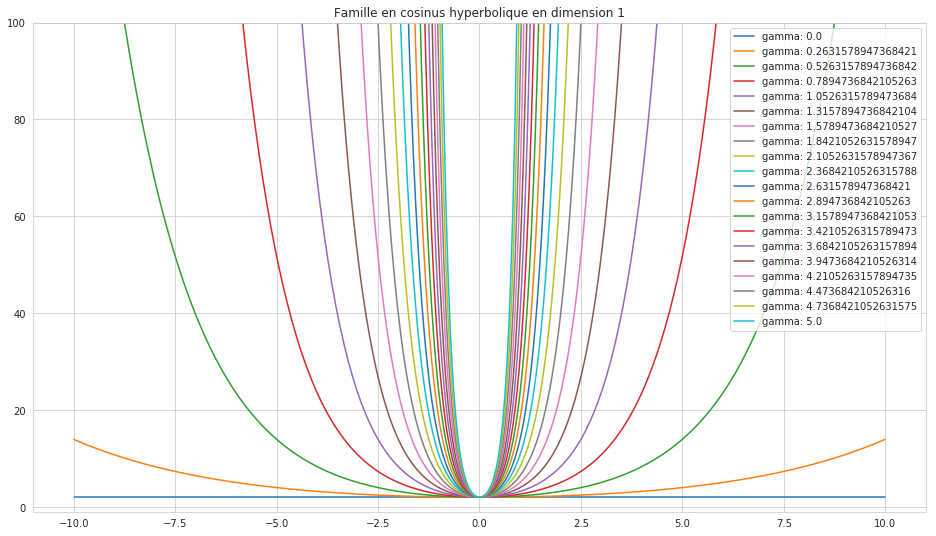

In [10]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(-10, 10, 400)
ax.set_ylim(-1, 100)
params = np.linspace(0, 5, 20)
for gamma in params:
    ax.plot(x, exp_I.value(x, gamma), label="gamma: {}".format(gamma))
ax.set_title("Famille en cosinus hyperbolique en dimension 1")
ax.legend()

In [11]:
multi_sinks_d = {
    "name": "multi_sinks_1",
    "dim" : 1,
    "nb_params" : 1,
    "convex" : False ,
    "value" : (lambda x, gamma: 20*np.cos(x**2) + (gamma * x**2)),
    "grad"  : (lambda x, gamma: np.sin(x) + 2*gamma*x),
    "hess"  : (lambda x, gamma: np.cos(x) + 2*gamma),
    "HCN"   : (lambda x, gamma: np.cos(x) + 2*gamma)   
}

multi_sinks = test_function(**multi_sinks_d)

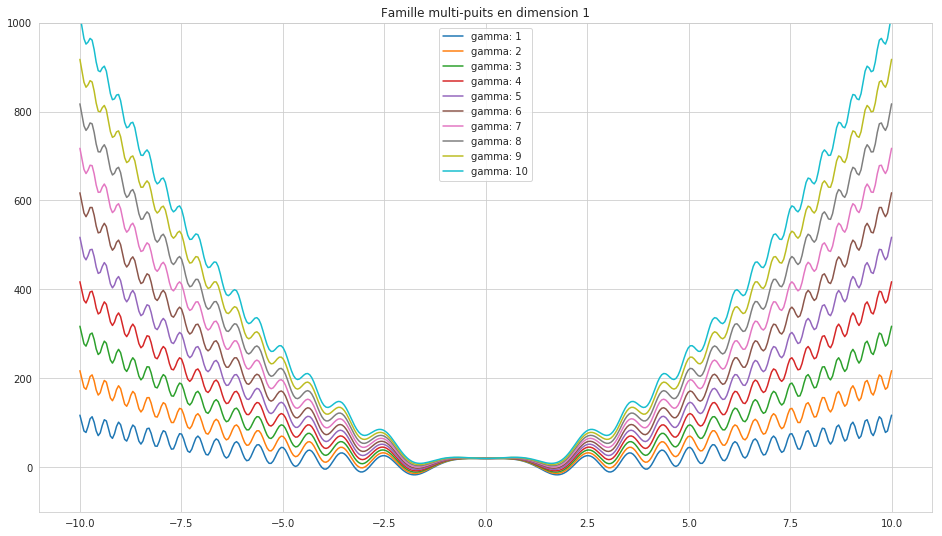

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(-10, 10, 400)
ax.set_ylim(-100, 1000)
for gamma in range(1, 11, 1):
    ax.plot(x, multi_sinks.value(x, gamma), label="gamma: {}".format(gamma))
ax.set_title("Famille multi-puits en dimension 1")
ax.legend()

2. Faire de même avec des fonctions sur $\mathbb{R}^2$.

In [13]:
quad_II_d = {
    "name": "quadric_2",
    "dim" : 2,
    "nb_params" : 1,
    "convex" : True ,
    "value" : (lambda x, gamma: x[:, 0]**2 + gamma*x[:, 1]**2),
    "grad"  : (lambda x, gamma: 2*x[:, 0] + 2*gamma*x[:, 1]),
    "hess"  : (lambda x, gamma: np.diag([2, 2*gamma])),
    "HCN"   : (lambda x, gamma: gamma)
}

quad_II = test_function(**quad_II_d)

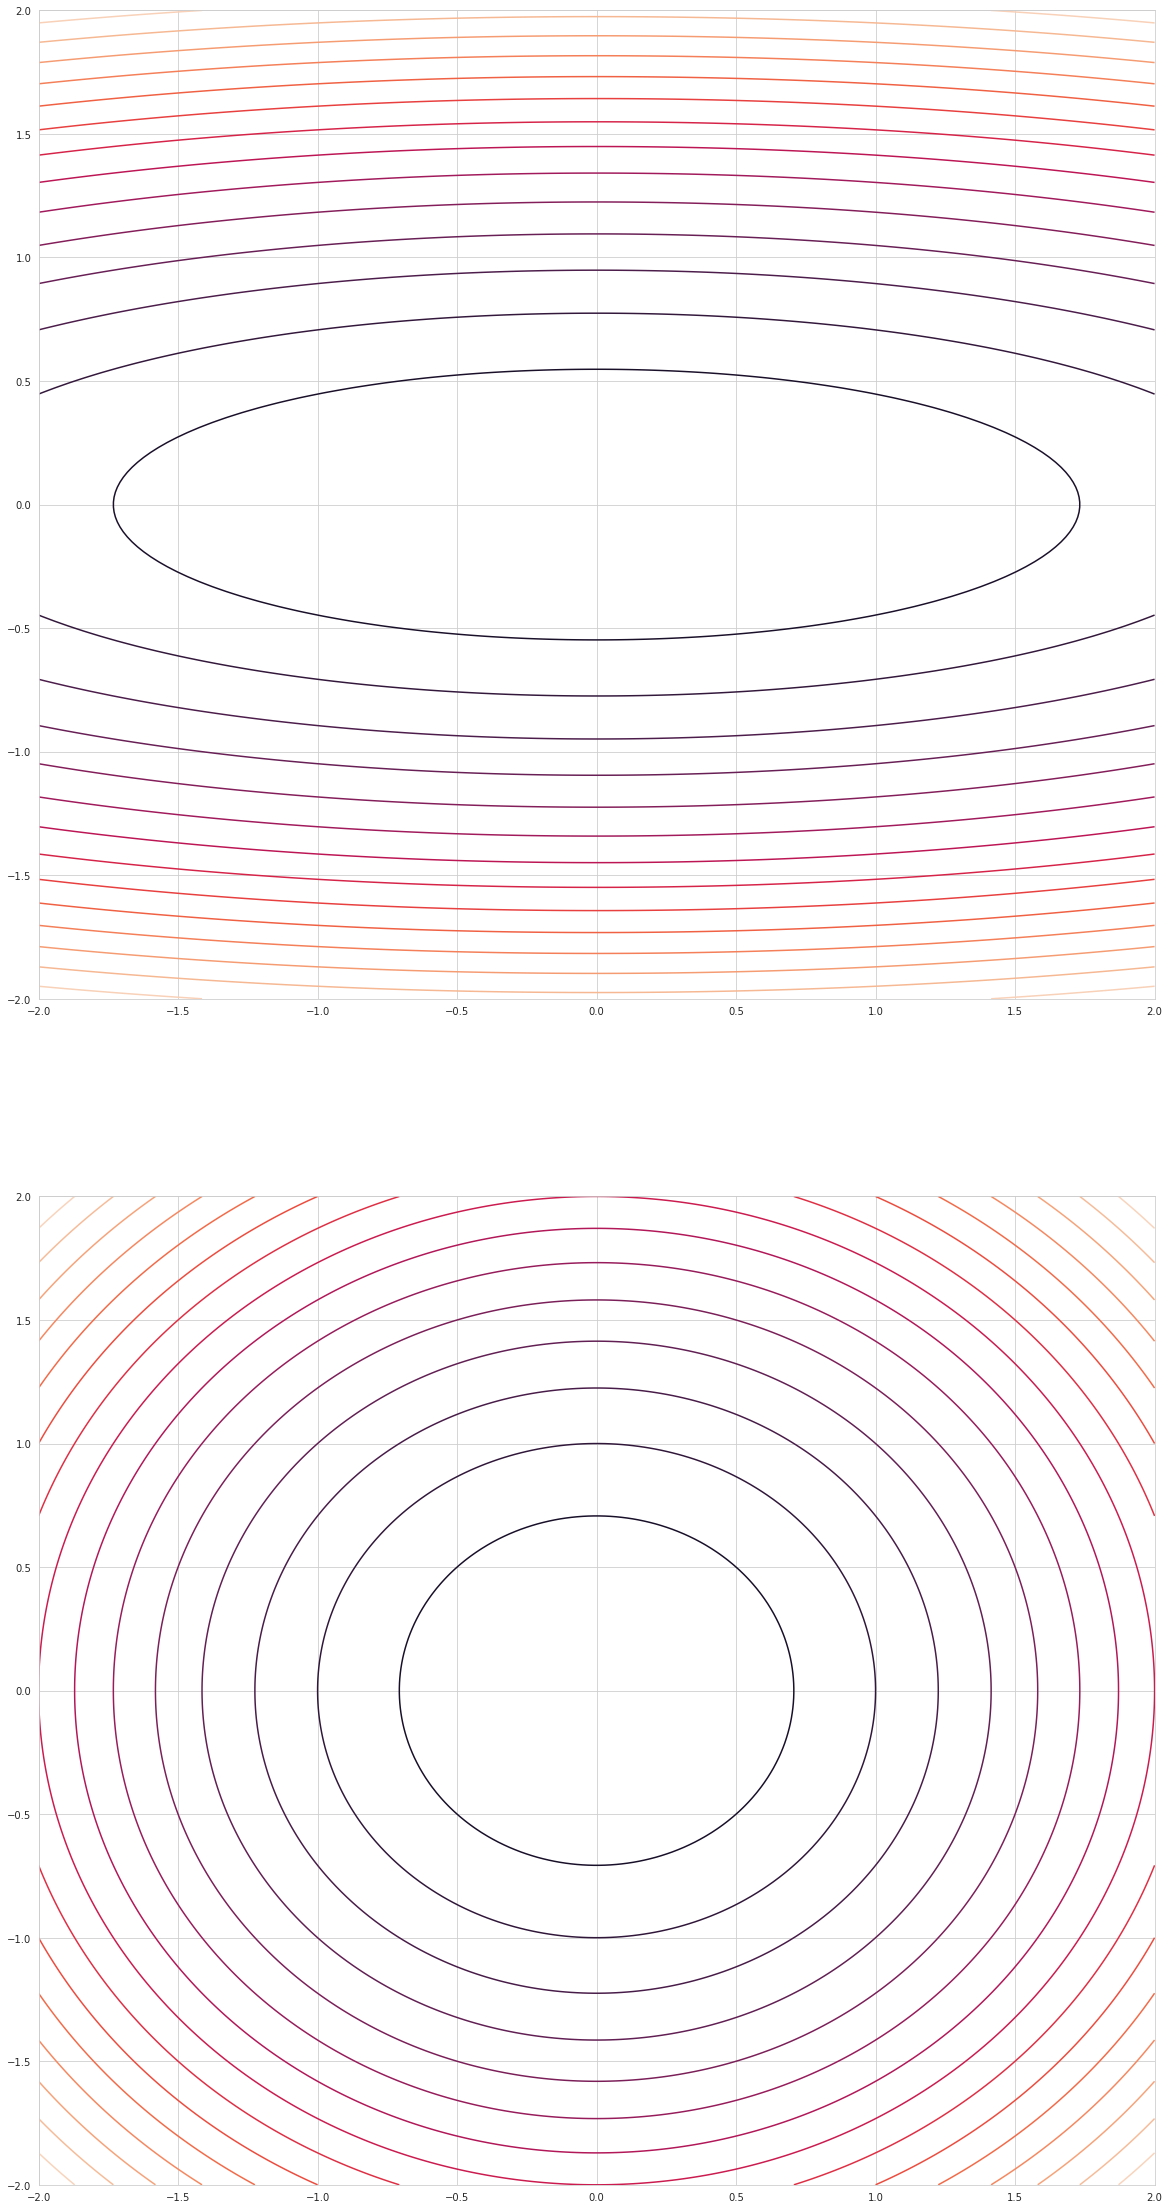

In [14]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -2, 2, -2, 2
fig, ax = plt.subplots(2, 1, figsize=(20, 40))
x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(x_mi, x_ma, nb_pts)
X, Y = np.meshgrid(x, y)
## Reshaping X, Y for proper evaluation by input function
x_y = np.vstack([X.reshape(1, -1), Y.reshape(1, -1)]).reshape(1, 2, -1)
for i in [0, 1]:
    ax[i].set_xlim(x_mi, x_ma)
    ax[i].set_ylim(y_mi, y_ma)
ax[0].contour(X, Y, quad_II.value(x_y, 10).reshape(nb_pts, -1), 15)
ax[1].contour(X, Y, quad_II.value(x_y, 1).reshape(nb_pts, -1), 15)

3. Construire des fonctions tests de dimensions de plus en plus grandes en fonction du paramètre.

4. Construire une `test_list` contenant la liste des familles de fonctions tests crées jusque là.

In [58]:
test_list = [quad_I, cubic_I, exp_I, multi_sinks, quad_II]

## Différencier une fonction

Pour calculer le gradient d'une fonction on a déjà besoin de savoir calculer la dérivée d'une fonction réelle. On s'intéresse à cette question dans cette section. Le point central est le fait qu'approcher numériquement la dérivée d'une fonction réelle est prone aux erreurs numériques ; on est souvent dans une meilleure posture lorsque l'on a une expression explicite pour le gradient d'une fonction.

### L'approche naïve

On rappelle que pour une fonction numérique le nombre dérivée d'une fonction $f : \mathbb{R} \to \mathbb{R}$ en un point $x \in \mathbb{R}$ est donnée par la limite :

$$ f'(x) = \lim_{h \to 0} \frac{f(x+h)-f(x)}{h} $$

quand celle-ci existe. D'un point de vue numérique une assez petite valeur $h$ donne un quotient suffisamment proche du nombre dérivée que l'on cherche. Ainsi pour $h$ assez petit on approche $f'(x)$ par 

$$ f'(x) \simeq \frac{f(x + h) - f(x)}{h} .$$

L'erreur à l'approximation est $o(1)$ en $0$. 

1. Coder une fonction `partial_` qui calcule la dérivée partielle d'une fonction à plusieurs variables en utilisant la démarche précédente.

In [16]:
def partial_(f, x, i=0, dx=1e-6):
    """Computes i-th partial derivative of f at point x.
    
    Args:
        f: objective function.
        x: point at which partial derivative is computed.
        i: coordinate along which derivative is computed.
        dx: slack for finite difference.
        
    Output:
        (float)

    """
    x = x.reshape(1, -1)
    h = np.zeros(x.shape)
    h[0, i] = dx
    return (f(x + h) - f(x)) / dx

2. Tester votre fonction sur un exmple dont vous connaissez la dérivée partielle et comparer vos résutlats.

In [17]:
partial_(lambda x: np.exp(x), np.array([100]))

array([[2.68811848e+43]])

In [18]:
np.exp(np.array([100]))

array([2.68811714e+43])

### Une démarche un peu moins naïve

On peut en réalité faire un peu mieux ; le nombre dérivée est également la limite 

$$ f'(x) = \lim_{h \to 0} \frac{f(x+h)-f(x-h)}{2h} $$.

On approche donc $f'(x)$ par 

$$f'(x) \simeq \frac{f(x+h)-f(x-h)}{2h}$$.

La différence avec la première approximation résulte de l'écriture du DL du numérateur de cette seconde écriture (en supposant $f$ deux fois différentiable:

$$f(x + h) - f(x - h) = (f(x) + hf'(x) + \frac{h^2}{2}f''(x) + o(h^2)) - (f(x) - hf'(x) + \frac{h^2}{2} f''(x) + o(h^2))$$

Et donc:

$$f(x + h) - f(x - h) = h^2f''(x) + o(h^2)$$.

On trouve que l'erreur d'approximation dans le second cas est désormais $o(h)$ ; ce qui est supposé être une meilleure approximation que dans le premier cas.

1. Utilisez la démarche précédente pour approcher la dérivée partielle d'une fonction en un point. Cette fonction sera notée `partial`.

In [19]:
def partial(f, x, i=0, dx=1e-6):
    """Computes i-th partial derivative of f at point x.
    
    Args:
        f: objective function.
        x: point at which partial derivative is computed.
        i: coordinate along which derivative is computed.
        dx: slack for finite difference.
        
    Output:
        (float)

    """
    x = x.reshape(1, -1)
    h = np.zeros(x.shape)
    h[0, i] = dx
    return (f(x + h) - f(x - h)) / (2*dx)

2. Comparer `partial` à `partial_` et à l'expression exacte de la dérivée partielle d'une fonction de votre choix. 

In [20]:
partial(lambda x: np.exp(x), np.array([100]))

array([[2.68811713e+43]])

In [21]:
np.exp(np.array([100]))

array([2.68811714e+43])

Il est possible de raffiner d'avantage l'estimation de la dérivée d'une fonction en un point. On se contente de ces deux premières approches simples.

### Le calcul du gradient

On sait déjà par la démarche précédente que l'approximation numérique de la dérivée partielle d'une fonction en un point sera difficilement meilleure qu'une expression exacte. Parfois on n'est pas en mesure de trouver facilement et à la main la dérivée partielle d'une fonction ; on se garde donc la possibilité de calculer numériquement le gradient d'une fonction.

- Écrire une fonction `gradient` qui renvoie le gradient d'une fonction en un point.

In [22]:
def gradient(f, x, dx=1e-6):
    """Computes gradient of f at point x.
    
    Args:
        f: objective function.
        x: point at which gradient is computed.
        dx: slack for finite difference of partial derivatives.
        
    Output:
        (ndarray) of size domain of f.
        
    """
    x = x.reshape(1, -1)
    dim = x.shape[1]
    return np.array([partial(f, x, i, dx) for i in range(dim)]).reshape(1, -1)

In [23]:
gradient(lambda x: x[0, 0]**5 + x[0, 1]*2, np.array([1, 10]))

array([[5., 2.]])

## La classe `GD`

La classe correspond à l'interface par laquelle on va implémenter et comparer les différentes variantes des descentes de gradients. L'objectif de cette section est de remplir les différents composants de calcul du principe qu'on a vu en cours. 

In [39]:
class GD():
    """Gradient Descent Object.
    
    Implements gradient descent aiming to compute optimal objective 
    value of convex functions and local optimal ones of none 
    convex functions.
    
    """    
    def __init__(self, ddir=None, rate=None, decay=None, tol=None, max_iter=None):
        """        
        Instantiates a GD object.
    
        Attributes:
        ddir: function computing descent direction.
        rate: function computing learning rate ; takes in
              - x (ndarray): current iterate
              - f (function): objective function
              - nb_iter (int): number of iterations.
              - eta (float): hyper-parameter.
        decay: function computing decay.
        tol: slack tolerance.
        max_iter: upper bound on number of iterations.
    
        """
        self.ddir = ddir if ddir else (lambda x, f, grad, tol: - grad(x, f, tol))
        self.rate = rate if rate else (lambda x, f, dir_x, nb_iter, eta : 0.01)
        self.decay = decay if decay else (lambda x, f, grad, tol: np.linalg.norm(grad(x, f, tol)))
        self.tol = tol if tol else 1e-6
        self.max_iter = max_iter if max_iter else 1000
    
    def __call__(self, x, f, grad, verbose=False):
        """Calling gradient descent object with specific starting point and optimal function.
        
        Args:
            x: initial starting point for descent.
            f: objective function of optimisation problem.
            grad: function outputing gradient value of function f at a given point.
        
        Output:
            (float) sub-optimal value up to tolerance if execution is proper.
            (ndarray) list of gradient descent iterates.
            (ndarray) list of graidents of iterates.
            (int) number of iterations.
            
        """
        x = x.reshape(1, -1)
        eta = 0
        n_iter = 0

        dir_x = self.ddir(x, f, grad, self.tol)
        rate_ = self.rate(x, f, dir_x, n_iter, eta)
        delta_x = rate_ * dir_x
        iters, iters_dir = x, delta_x
        
        decay_x = self.decay(x, f, grad, self.tol)
        while decay_x > self.tol and n_iter < self.max_iter:
            ## Deciding on direction
            dir_x = self.ddir(x, f, grad, self.tol)
            rate_ = self.rate(x, f, dir_x, n_iter, eta)
            delta_x =  rate_ * dir_x
            
            ## Updating iterate
            x = x + delta_x
            
            ## Storing on-going data
            iters_dir = np.vstack([iters_dir, delta_x])
            iters = np.vstack([iters, x])
            
            ## Computing decay
            decay_x = self.decay(x, f, grad, self.tol)
            
            ## Updating iteration number
            n_iter += 1
            
        if decay_x > self.tol:
            warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)
        
        if verbose:
            msg = " Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}."
            print(msg.format(n_iter, x.flatten(), f(x), decay_x))
        
        return (x, iters, iters_dir, n_iter) 

### GD dans le cas d'un pas constant

Pour être en mesure de faire nos premiers tests d'utilisation de `GD` il nous faut encore se préoccuper des quelques hyperparamètres à fixer. On commence en un premier temps par tester la descente de gradient classique à pas constants.
 

1. Mettre les valeurs par défaut pour les attributs de `GD` de facon à obtenir une descente de gradients classique à pas constant et une condition d'arrêt donnée par le fait que le gradient en un point tombe en-deca d'un certain seuil de tolérance.

Voir la classe plus haut.

2. Tester cette descente de gradient classique sur les différentes fonctions tests. Répertorier dans un tableau le point initial de chaque descente, le nombre d'itérations, le pas choisi et la valeur objectif obtenue.

Cherchons d'abord à manipuler la classe qu'on vient de construire

In [40]:
GD_default = GD()

In [42]:
op_pt, iters, iters_dir, n_iter = GD_default(np.array([10]), (lambda x : quad_I.value (x, 2)), 
                                             (lambda x, f, tol : quad_I.grad (x, 2)), True)

 Iteration nu. = 430
 approx. = [-0.24999976]
 ob value = [[0.875]]
 and decay = 9.759196527570069e-07.


On se contente ici de travailler avec les fonctions tests de dimension $1$.  

In [62]:
test_list_d1 = [test_family for test_family in test_list if test_family.dim == 1]

In [63]:
init_pt = np.array([10])

In [90]:
gamma = 1

In [99]:
cst_rate = 0.01

In [100]:
import pandas as pd

In [109]:
GD_test_summary = pd.DataFrame(columns=["init_pt", "rate", "optimal_pt", "nb_iter"])
GD_list = {}
for t_function in test_list_d1:
    idt = 0
    GD_list[t_function.name] = GD(rate = lambda x, f, dir_x, nb_iter, eta : cst_rate)
    opt_pt, _, _, n_iter = GD_list[t_function.name](init_pt, 
                                                    (lambda x: t_function.value (x, gamma)), 
                                                    (lambda x, f, tol : t_function.grad(x, gamma)))
    naming_format = "{}_{}".format(t_function.name, idt)
    GD_test_summary.loc[naming_format] = pd.Series({"init_pt": init_pt, 
                                                     "rate": GD_list[t_function.name].rate (*[None]*5), 
                                                     "optimal_pt": opt_pt, 
                                                     "nb_iter": n_iter})
    idt += 1
GD_test_summary

/home/bashar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in multiply
  import sys
/home/bashar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in add
/home/bashar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/home/bashar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in add
  import sys
/home/bashar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/home/bashar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: Decay didn't get under tolerance rate.
/home/bashar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sin
  import sys


,init_pt,rate,optimal_pt,nb_iter
quadratic_1_0,[10],1.0,[[nan]],242
cubic_1_0,[10],1.0,[[-inf]],8
exp_1_0,[10],1.0,[[-inf]],1000
multi_sinks_1_0,[10],1.0,[[-inf]],241


3. Étudier pour un sous-ensemble de votre choix la relation entre le pas de la descente et le nombre d'itérations. Prendre soins de bien vérifier que vous avez convergence.

In [103]:
init_pt = np.array([10])

In [112]:
gammas = np.linspace(1, 10, 10)

In [113]:
cst_rates = np.linspace(0.01, 1, 20)

In [115]:
GD_rate_iter = pd.DataFrame(columns=["rate", "optimal_pt", "nb_iter"])
GD_list_ri = {}
for t_function in test_list_d1:
    for gamma in gammas:
        idt = 0
        for cst_rate in cst_rates:
            GD_list_ri[t_function.name] = GD(rate = lambda x, f, dir_x, nb_iter, eta : cst_rate)
            opt_pt, _, _, n_iter = GD_list_ri[t_function.name](init_pt, 
                                                               (lambda x: t_function.value (x, gamma)), 
                                                               (lambda x, f, tol : t_function.grad(x, gamma)))
            naming_format = "{}_{}_{}".format(t_function.name, idt, gamma)
            GD_rate_iter.loc[naming_format] = pd.Series({"gamma": gamma, 
                                                         "rate": GD_list_ri[t_function.name].rate (*[None]*5), 
                                                         "optimal_pt": opt_pt, 
                                                         "nb_iter": n_iter})
            idt += 1
GD_rate_iter

/home/bashar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: Decay didn't get under tolerance rate.
/home/bashar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in multiply
  import sys
/home/bashar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in add
/home/bashar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/home/bashar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in add
  import sys
/home/bashar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/home/bashar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sin
  import sys


,rate,optimal_pt,nb_iter
quadratic_1_0_1.0,0.010000,[[-0.49999950459258535]],835
quadratic_1_1_1.0,0.062105,[[-0.499999555006582]],128
quadratic_1_2_1.0,0.114211,[[-0.4999996124803972]],66
quadratic_1_3_1.0,0.166316,[[-0.4999995588901985]],42
quadratic_1_4_1.0,0.218421,[[-0.4999996531876127]],30
quadratic_1_5_1.0,0.270526,[[-0.499999619834461]],22
quadratic_1_6_1.0,0.322632,[[-0.4999997657949129]],17
quadratic_1_7_1.0,0.374737,[[-0.4999998392011746]],13
quadratic_1_8_1.0,0.426842,[[-0.49999967729176076]],9
quadratic_1_9_1.0,0.478947,[[-0.4999999414930289]],6


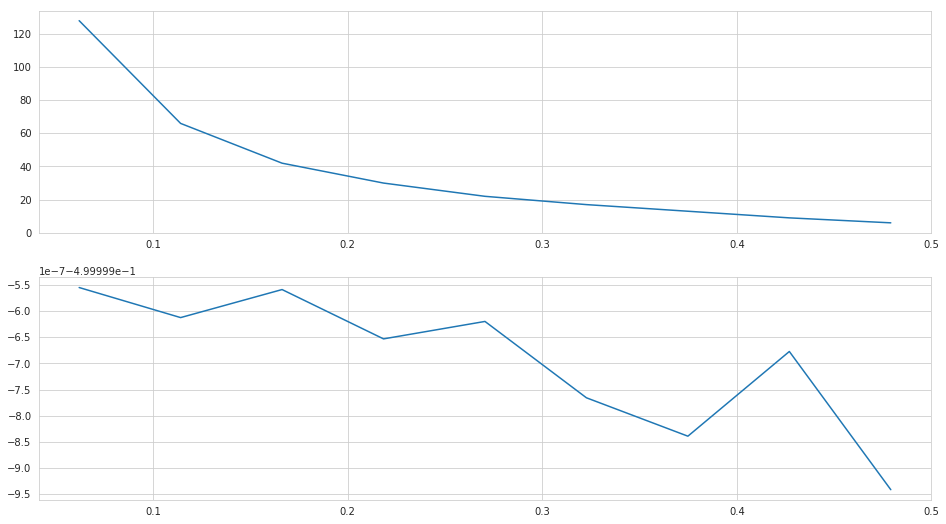

In [133]:
fig, ax = plt.subplots(2, 1, figsize=(16, 9))
ax[0].plot(GD_rate_iter["rate"][1:10], GD_rate_iter["nb_iter"][1:10])
ax[1].plot(GD_rate_iter["rate"][1:10], GD_rate_iter["optimal_pt"][1:10])

4. Étudier la relation entre la vitesse de convergence et le point initial de votre descente dans le cas des fonctions numériques.

### GD dans le cas de *backtracking*

Vous devriez avoir constatés que le choix du pas de descente dans le cas constant est crucial pour garantir la convergence de l'algorithme de descente. Dans cette section on s'intéresse à un calcul adaptatif du pas de descente qui permet de mieux garantir la convergence de notre algo. Le désavatage est le temps que prend désormais chaque itération pour s'exécuter.

1. Écrire une fonction `backtracking` qui permet de calculer le pas par *backtracking* à une itération donnée. Pour rappel le *backtracking* a deux hyper-paramètre $\alpha$ et $\beta$ respectivement mis par défaut à $0.01$ et $0.08$.

In [135]:
class backtracking():
    
    def __init__(self, alpha=0.01, beta=0.8, max_iter=100):
        self.alpha = alpha
        self.beta = beta
        self.max_iter = max_iter
        
    def __call__(self, f, x, dir_x, grad, tol=1e-6, n_iter=None):
        n_while = 0
        t = 1
        x = x.reshape(1, -1)
        grad_f = grad(x, f, tol)
        while f(x + t * dir_x) > f(x) + self.alpha * t * grad_f.dot(dir_x.T) and n_while < self.max_iter:
            t = self.beta * t
            n_while += 1
        return t

2. Comparer la GD par backtracking aux tests effectués jusqu'à présent dans le cas d'une GD à pas constant (à vous de réfléchir à ce que vous voulez comparer).

### Changer de direction de descente

On a explicité en cours trois types de descentes : 

 - La déscente standard : la direction de descente est celle du gradient, ce qu'on vient de regarder.
 - La déscente de plus forte pente dans le cas de la norme $\ell_1$ : la direction de descente suit le vecteur de la base canonique de plus grande dérivée partielle en valeur absolue.
 - L'algorithme de Newton où il s'agit de calculer l'inverse des hessiennes au point courant. 
 
*L'algorithme de Newton sera abordé dans une section à part.* On va donc se concentrer pour commencer sur le cas de descente en norme $\ell_1$. 
 

1. Écrire une fonction `dsgd` qui calcule la direction de descente de plus forte pente dans le cas de la norme $\ell_1$. 

In [138]:
def dsgd(x, f, grad, tol=1e-6):
    x = x.reshape(1, -1)
    dim = x.shape[1]
    sdescent = np.array([0]*dim, dtype=float).reshape(1, -1)
    grad_f = grad(x, f, tol)
    abs_grad = np.abs(grad_f)
    imax_diff = np.argmax(abs_grad) 
    sdescent[0, imax_diff] = grad[0, imax_diff]
    return (- sdescent)      

2. Comparer la descente de gradient $\ell_1$ à la descente classique.

## Sensibilité de GD aux conditionnements de la hessienne

On s'intéresse dans cette section au comportement de la descente de gradients vis-à-vis de la géométrie locale de l'itéré courant. Cette étude va vous permettre de comprendre en quoi le manque de symétrie locale des fonctions objectifs rend plus lente la convergence de la descente de gradient.

1. En utilisant la GD classique à pas constant tracer dans les cas de nombres de conditionnements qui ne dépendent que des paramètres de vos familles tests ce nombre contre le nombre d'itérations de la GD.

2. Faire de même avec le cas de *backtracking*

3. Que constatez-vous?

## Accélérations

Il y a des stratégies standards d'accélération de descente de gradients ; on en invente même tous les ans. Il n'y a pas nécessairement de relation d'ordre entre celles-ci, certaines sont plus adaptées que d'autres à des problèmes spécifiques et inversement. On propose d'en implémenter $3$ ici, il s'agit en particulier d'un travail bibliographique (simple).

1. Implémenter la *Momentum Optimisation*. Cherchez à en comprendre le sens.

2. Implémenter la *Nesterov Optimisation*. Cherchez à en comprendre le sens.

3. Implémenter la *Adam Optimisation*. Cherchez à en comprendre le sens.

4. Comparer les descentes de gradient pour chacune des optimisations précédentes.

## Méthode de Newton

1. Implémenter la méthode de Newton.

2. Qu'est-ce qu'un exemple pertinent pour comparer la méthode de Newton au méthode de descente vu précédemment?

3. Comparer la méthode de Newton aux exemples précédents.

## Cas pratique : la régression (YAT)

**TODO**